In [4]:
import numpy as np
np.set_printoptions(suppress = True)
from importlib import reload
import functions
from functions import *
import arithmetic
from arithmetic import *
functions = reload(functions)
arithmetic = reload(arithmetic)

In [29]:
b = 3
qasm_qc = QuantumCircuit(b, b)
QFT(qasm_qc, b, delta=8)
qasm_output = qasm_qc.qasm()

In [30]:
with open("qasm_files/qasm{}qubit".format(b), 'w') as txt_file:
    txt_file.write(qasm_output)

In [ ]:
n_low = 2
n_high = 32
compareFTs(n_low, n_high, backend="statevector", display_bool=False)

errors2-32.txt
n=2, i=0
progress: 50.00%
--- 0.010s seconds ---
n=3, i=1
progress: 33.33%
progress: 66.67%
--- 0.038s seconds ---
n=4, i=2
progress: 25.00%
progress: 50.00%
progress: 75.00%
--- 0.085s seconds ---
n=5, i=3
progress: 20.00%
progress: 40.00%
progress: 60.00%
progress: 80.00%
--- 0.179s seconds ---
n=6, i=4
progress: 16.67%
progress: 33.33%
progress: 50.00%
progress: 66.67%
progress: 83.33%
--- 0.301s seconds ---
n=7, i=5
progress: 14.29%
progress: 28.57%
progress: 42.86%
progress: 57.14%
progress: 71.43%
progress: 85.71%
--- 0.476s seconds ---
n=8, i=6
progress: 12.50%
progress: 25.00%
progress: 37.50%
progress: 50.00%
progress: 62.50%
progress: 75.00%
progress: 87.50%
--- 0.797s seconds ---
n=9, i=7
progress: 11.11%
progress: 22.22%
progress: 33.33%
progress: 44.44%
progress: 55.56%
progress: 66.67%
progress: 77.78%
progress: 88.89%
--- 1.109s seconds ---
n=10, i=8
progress: 10.00%
progress: 20.00%
progress: 30.00%
progress: 40.00%
progress: 50.00%
progress: 60.00%
progr

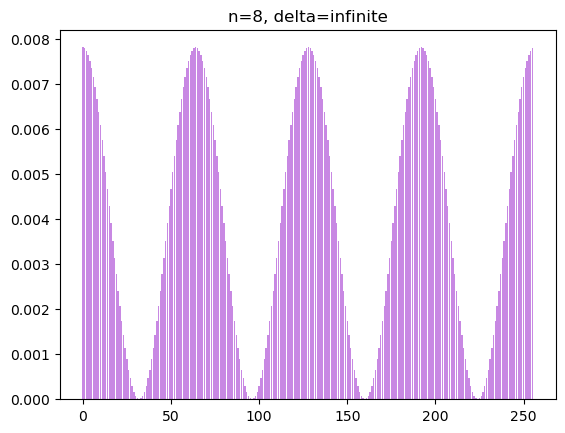

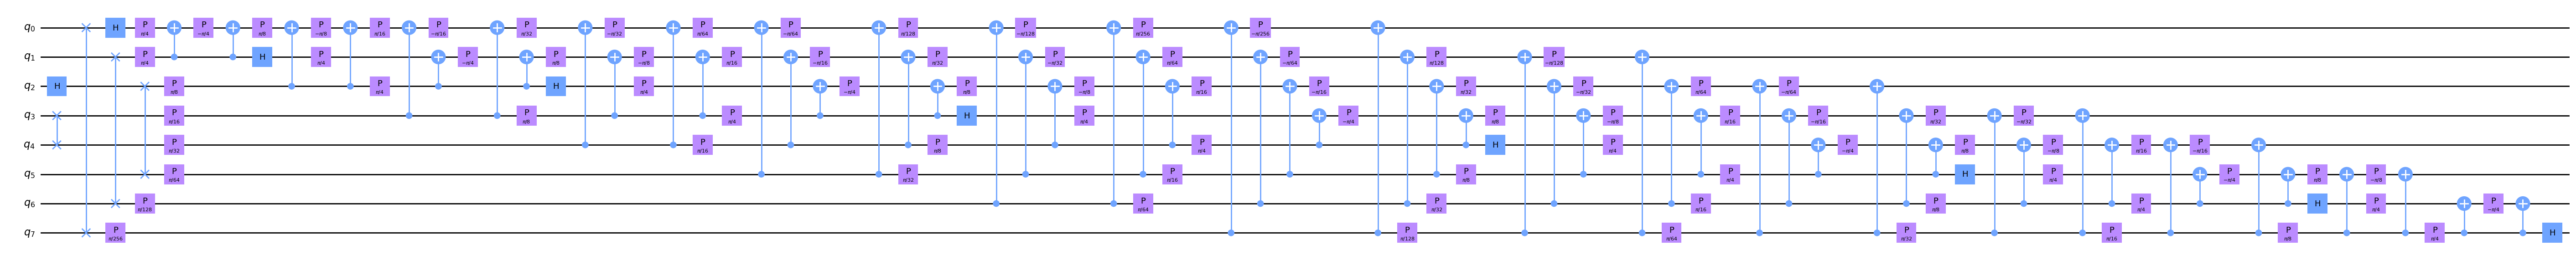

<Figure size 640x480 with 0 Axes>

In [32]:
n = 8
ac = QuantumCircuit(n)
ac.h(2)
QFT(ac, n)

probs = simulateQFT(ac, n, display_bool=True)

ac.draw(output="mpl", fold=-1)

min_n = 2, max_n = 28, min_d = 1, max_d = 27
(28, 27)
x = 2, y = 1, data = 1.6697788640876683e-34
x = 3, y = 1, data = 0.06250000000000006
x = 3, y = 2, data = 0.0
x = 4, y = 1, data = 0.03125000000000003
x = 4, y = 2, data = 3.469446951953614e-18
x = 4, y = 3, data = 6.938893903907228e-18
x = 5, y = 1, data = 0.023437500000000014
x = 5, y = 2, data = 0.007812500000000014
x = 5, y = 3, data = 3.7947076036992655e-18
x = 5, y = 4, data = 5.095750210681871e-18
x = 6, y = 1, data = 0.01171875000000001
x = 6, y = 2, data = 0.003906250000000007
x = 6, y = 3, data = 5.8817967857338616e-18
x = 6, y = 4, data = 6.152847328855238e-18
x = 6, y = 5, data = 1.734723475976807e-18
x = 7, y = 1, data = 0.006835937500000006
x = 7, y = 2, data = 0.002929687500000008
x = 7, y = 3, data = 0.0009765625000000043
x = 7, y = 4, data = 2.930733997499879e-18
x = 7, y = 5, data = 1.9786689647860456e-18
x = 7, y = 6, data = 1.2536087619363645e-18
x = 8, y = 1, data = 0.003417968750000003
x = 8, y = 2, data = 0.00

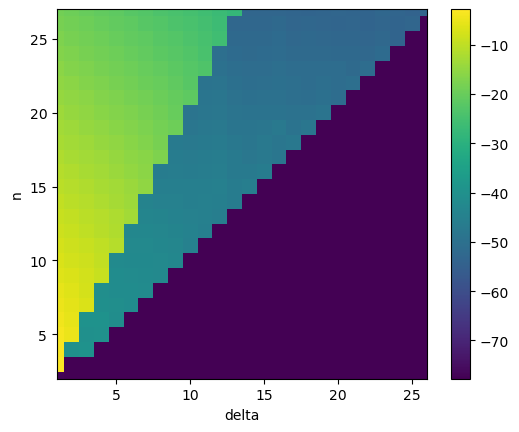

In [3]:
plotErrorsFromFile("txt/errors2-32.txt")

In [7]:
from qiskit import QuantumRegister, ClassicalRegister

n = 2
N = 3*n+1
qr = QuantumRegister(N, "qr")
cr = ClassicalRegister(N, "cr")
qc = QuantumCircuit(qr, cr)

# indices of a: 1, 4, 7, ...
# indices of b: 2, 5, 8, ...
# indices of sum: 2, 5, 8, ...

qc.x(1)
qc.x(2)
qc.x(4)
qc.x(5)

qc.append(nBitAdder(n), [qr[i] for i in range(N)])

qc.measure(range(N), range(N))
decomposed = qc.decompose(reps=2)
qc.draw(output="mpl", fold=-1, filename="circuits/{}-bitAdderDecomposed.png".format(n))

simulator = Aer.get_backend('qasm_simulator')
job_sim = simulator.run(qk.transpile(qc, simulator), shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)

{'1110010': 1024}


{'0000011000011': 1024}


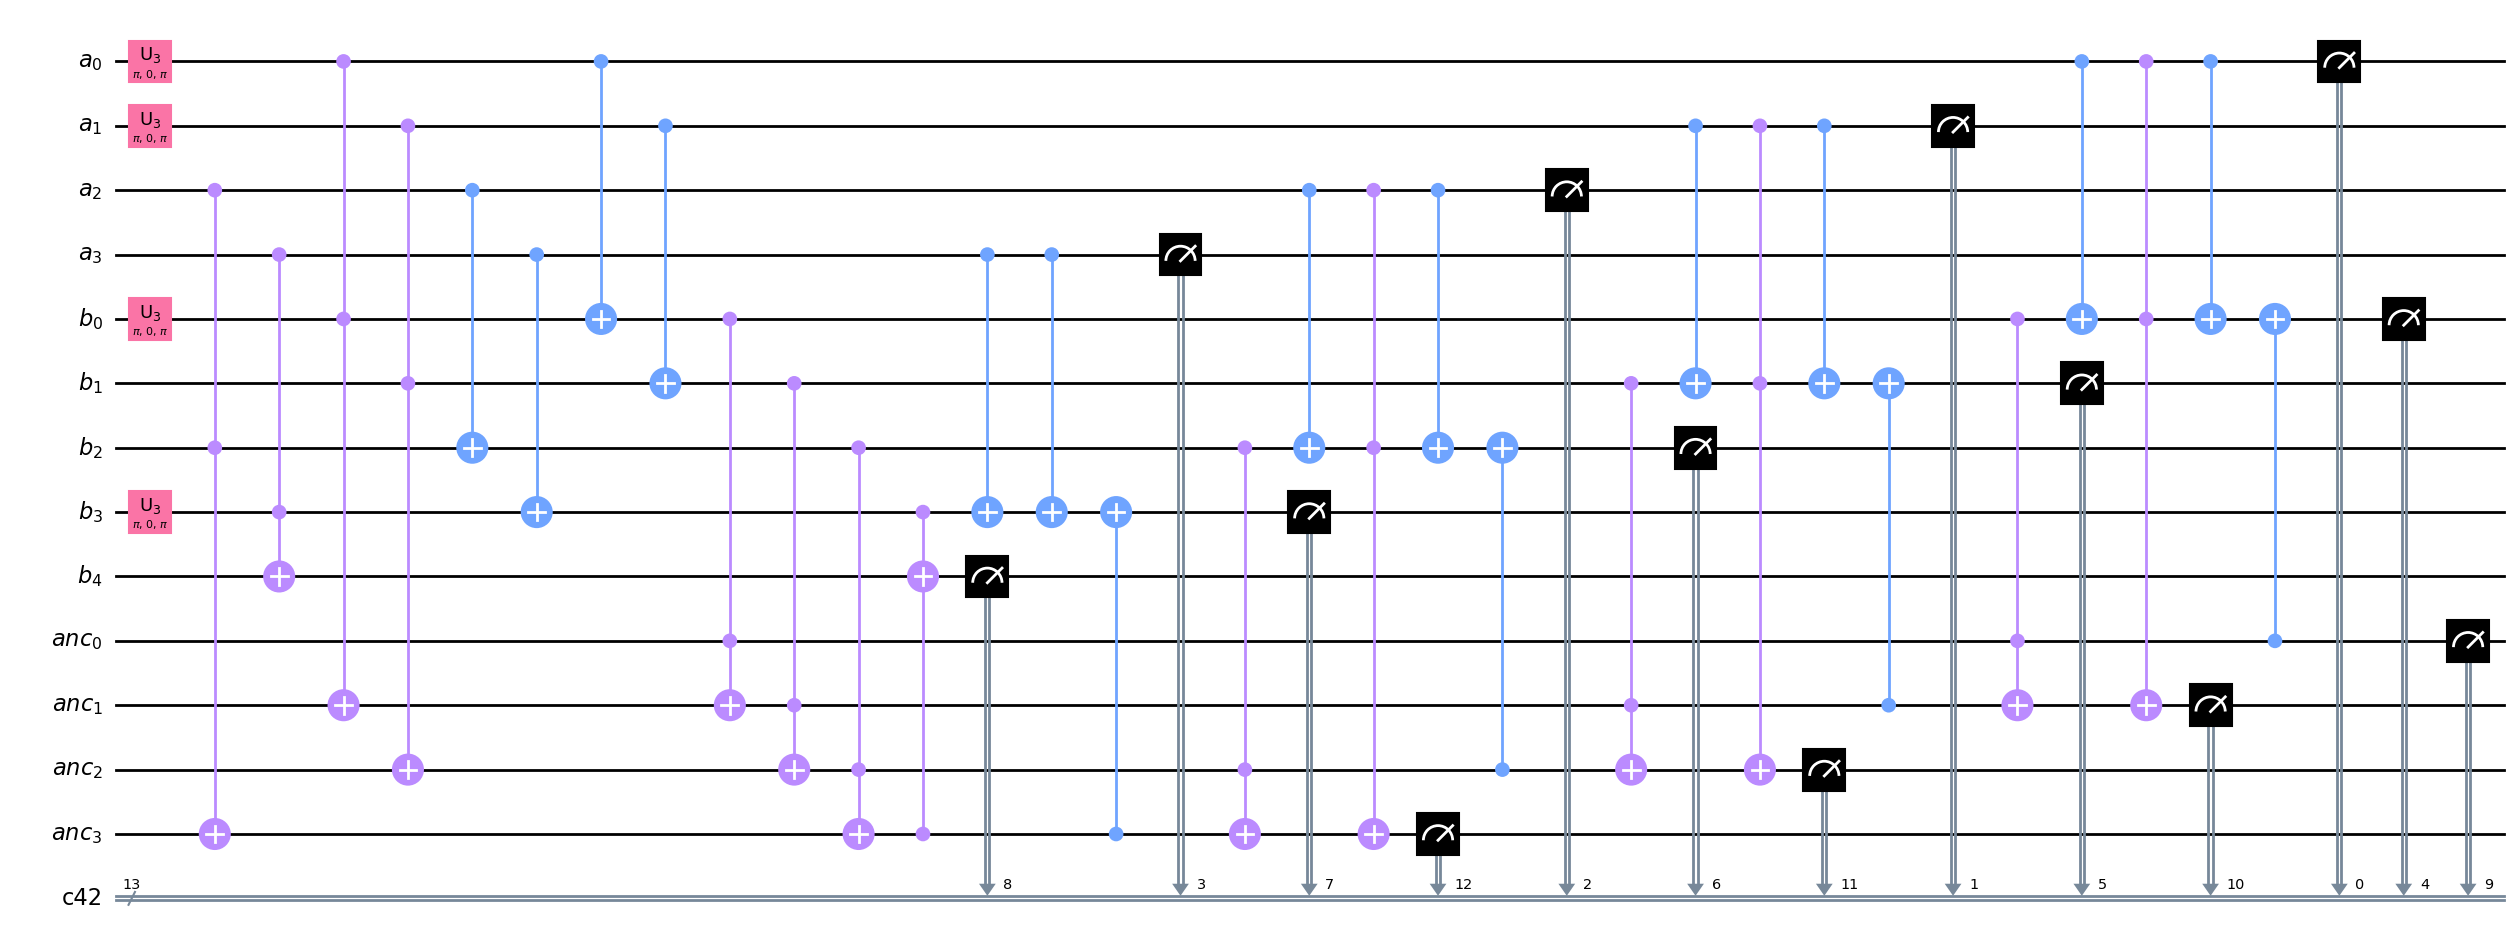

In [53]:
# rewrite the adder functions to work on registers
n = 4
N = 3*n+1


reg_a = QuantumRegister(n, name="a")
reg_b = QuantumRegister(n + 1, name="b")
reg_anc = QuantumRegister(n, name="anc")
cr = ClassicalRegister(N)

qc = QuantumCircuit(reg_a, reg_b, reg_anc, cr, name="{}-bit adder".format(n))

qc.x(0)
qc.x(1)
# qc.x(2)
# qc.x(3)

qc.x(4)
# qc.x(5)
# qc.x(6)
qc.x(7)

for i in range(n):
    try:
        qc.append(twoBitCarry(), [reg_anc[i], reg_a[i], reg_b[i], reg_anc[i + 1]])
    except:
        qc.append(twoBitCarry(), [reg_anc[i], reg_a[i], reg_b[i], reg_b[i + 1]])
qc.cnot(reg_a[-1], reg_b[-2])

# sum_bitlist = [-4, -3, -2]
# rev_carry_bitlist = [-7, -6, -5, -4]

qc.append(twoBitSum(), [reg_anc[-1], reg_a[-1], reg_b[-2]])
for i in range(n - 1):
    # qc.append(reverseTwoBitCarry(), [qr[x - 3 * i] for x in rev_carry_bitlist])
    qc.append(reverseTwoBitCarry(), [reg_anc[-2 - i], reg_a[-2 - i], reg_b[-3 - i], reg_anc[-1 - i]])
    qc.append(twoBitSum(), [reg_anc[-2 - i], reg_a[-2 - i], reg_b[-3 - i]])

qc.draw(output="mpl", fold=-1) #, filename="circuits/{}-bitAdder.png".format(n))

qc.measure(range(N), range(N))

decomposed = qc.decompose(reps=1)
#
simulator = Aer.get_backend('qasm_simulator')
job_sim = simulator.run(qk.transpile(qc, simulator), shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)

decomposed.draw(output="mpl", fold=-1, filename="circuits/{}-bitAdderDecomposed.png".format(n))